# How to make a mini-Qiskit from scratch with TensorNetwork

We are going to create the QuantumCircuit class from Qiskit using only Tensor Networks, leveraging the Tensor Network library. This is a miniature version to help understand a bit how it would be done.

## Packages

We will use the following libraries to create and manage tensors (Numpy), contract and name tensors (tensornetwork), compress MPS (tntorch and torch), and plot circuits (matplotlib).

In [1]:
# Imported modules
import numpy as np
import tensornetwork as tn

import matplotlib.pyplot as plt
from matplotlib import rcParams

from auxiliary_functions import TT_State_Compression, process_axes

# Parameters for plots
plt.style.use('dark_background')
rcParams.update({'xtick.labelsize': 25, 'ytick.labelsize': 25, 'font.size': 30})

---
# TNCircuit class

This is the parent class that will store the tensors, perform general contractions and compressions.

To initialize the object, we must pass the following arguments:

- n_qudits: number of 'qudits' in the system.
- dimension_qudits: dimension of the qudits. For qubits, set to 2.

The methods it has are the following:
- append_operator: receives an operator as a list of lists of tensors (to include operators with more than one layer) and the series of qubits to which it should be applied. The method adds these tensor layers at the first available time for all involved qudits, creating a new time if necessary. Modifies self.tensors.
Input:

    - operator: list of lists of tensors to add to the circuit.
    - qudits:   list of qudits for each element of the operator.

- contract: receives a scheme from among `'time', 'spatial'` (although spatial is not implemented for the reasons mentioned in the document) and a representation style from among `'statevector', 'MPS', 'density operator', 'PEPS'` (although for simplicity only statevector and MPS are implemented). This method contracts the tensor network along the line received by the scheme, and maintains the tensor shape in the indicated representation. For example, if we select time and MPS, at each step we will have the MPS form for that time step, contracting each 'qudit' only with its corresponding operations. Additionally, we can add an eps that will tell us the maximum error allowed in the MPS compression of tntorch (only available for MPS with real numbers). If eps=0, then we do not approximate. Input:
    - scheme: contraction scheme.
    - representation: type of state representation.
    - eps: maximum error for compression.

Its attributes are:
- tensors: list of lists of tensors in Tensornetwork Node format. There are two indices to find a tensor. The first tells us the time step of that tensor and the second tells us the qudit where it is located. That is,
`tensors[time][qudit]=Node`. If there is no operation at that (time, qudit) pair, there will be a None at that position. The axes will always respect this order:
`'in','out','up','down'`, these being the indices that connect towards 'before', 'after', 'above' and 'below' in the quantum circuit.
- n_qudits: number of qudits.
- dimension_qudits: dimension of the qudits.
- depth: depth of the circuit.
- current_MPS: stores the MPS of the tensor network, in case it is to be used later for extended methods (not implemented as they fall outside the scope of the task).

In [2]:
class TNCircuit:
    """Parent class for storing tensors and performing general contractions and compressions."""

    def __init__(self, n_qudits: int, qudits_dimension: int = 2):
        """Initialize a tensor network circuit.

        Args:
            n_qudits: Number of qudits in the system.
            qudits_dimension: Dimension of the qudits (default: 2 for qubits).
        """
        # Create initial state tensor |0⟩
        initial_tensor = np.zeros(qudits_dimension, dtype=complex)
        initial_tensor[0] = 1
        
        # Initialize first layer with all qudits in |0⟩ state
        self.tensors = [
            [
                tn.Node(initial_tensor, name=f'|0>_{qudit}', axis_names=['out'])
                for qudit in range(n_qudits)
            ]
        ]

        # Store circuit parameters
        self.n_qudits = n_qudits
        self.dimension_qudits = qudits_dimension

        # Initialize circuit depth
        self.depth = 1

    #---------------------------------------------------------------------------
    def append_operator(self, operator: list, qudits: list):
        """Add an operator to the circuit at the earliest available time.
        
        Receives an operator as a list of lists of tensors (to include operators 
        with more than one layer) and the series of qubits to which it should be applied.
        The method adds these tensor layers at the first available time for all 
        involved qudits, creating new time steps if necessary.
        
        Args:
            operator: List of lists of tensors to add to the circuit. Each sublist
                     represents a layer, and each element in a sublist is a tensor
                     for the corresponding qudit.
            qudits: List of qudit indices for each element of the operator.
        
        Modifies:
            self.tensors: Updates the tensor network with the new operator.
            self.depth: May increase if new time steps are needed.
        """
        # Number of layers and qudits involved
        n_layers = len(operator)
        n_qudits_operator = len(qudits)

        # Validate input
        assert n_qudits_operator <= self.n_qudits, \
            f'The number of qudits in the gate ({n_qudits_operator}) must not exceed ' \
            f'the number of qudits in the circuit ({self.n_qudits})'

        # Find the first available time position
        # Start by assuming we need a new time step
        t_free = self.depth
        
        # Search backwards through existing time steps
        for t in range(self.depth - 1, -1, -1):
            # Check if this time step is free for all required qudits
            is_free = all(self.tensors[t][qudit] is None for qudit in qudits)
            
            if is_free:
                # This time step is available
                t_free = t
            else:
                # Found a conflict; can't go further back due to non-commutativity
                break

        # Calculate how many new time steps we need
        time_steps_needed = (t_free + n_layers) - self.depth
        
        if time_steps_needed > 0:
            # Add new time steps
            new_layers = [[None for _ in range(self.n_qudits)] for _ in range(time_steps_needed)]
            self.tensors.extend(new_layers)
            self.depth += time_steps_needed

        # Add the operator tensors to the circuit
        for layer_idx in range(n_layers):
            for qudit_idx in range(n_qudits_operator):
                target_time = t_free + layer_idx
                target_qudit = qudits[qudit_idx]
                self.tensors[target_time][target_qudit] = operator[layer_idx][qudit_idx]

    #---------------------------------------------------------------------------
    def contract(self, scheme: str='time', representation: str='statevector', eps: float=0):
        """Contract the tensor network according to the specified scheme and representation.
        
        Args:
            scheme: Contraction scheme ('time' or 'spatial'). Only 'time' is implemented.
            representation: State representation ('statevector' or 'MPS'). 
                           Other options like 'density operator' and 'PEPS' are not implemented.
            eps: Maximum error tolerance for MPS compression (only for real-valued MPS).
                If eps=0, no approximation is applied.
        
        Returns:
            The contracted tensor network in the specified representation.
            
        Note:
            - Spatial contraction is not implemented due to complexity.
            - For 'time' + 'statevector': contracts all tensors into a single statevector.
            - For 'time' + 'MPS': maintains MPS form at each time step with optional compression.
        """
        if scheme == 'time':  # Contract along the time dimension
            if representation == 'statevector':  # Full statevector representation
                # Track the most recent time step for each qudit
                last_layer = np.zeros(self.n_qudits, dtype=int)
                
                # Connect tensors across time steps
                for t in range(1, self.depth):
                    # Connect each qudit to its previous time step
                    for qudit in range(self.n_qudits - 1):
                        if self.tensors[t][qudit] is not None:
                            # Connect input edge to output of previous time step
                            self.tensors[t][qudit]['in'] ^ self.tensors[last_layer[qudit]][qudit]['out']
                            last_layer[qudit] = t
                            
                            # Connect spatial edges (down/up) for multi-qudit gates
                            if 'down' in self.tensors[t][qudit].axis_names:
                                self.tensors[t][qudit]['down'] ^ self.tensors[t][qudit + 1]['up']
                    
                    # Handle the last qudit separately (no 'down' edge)
                    if self.tensors[t][-1] is not None:
                        self.tensors[t][-1]['in'] ^ self.tensors[last_layer[-1]][-1]['out']
                        last_layer[-1] = t
                
                # Contract the initial time step (t=0)
                current_tensor = self.tensors[0][0]
                for qudit in range(1, self.n_qudits):
                    # Use outer product for unconnected tensors in the same layer
                    current_tensor = tn.contract_between(
                        current_tensor, 
                        self.tensors[0][qudit], 
                        name=f'state^{qudit}_0',
                        allow_outer_product=True
                    )
                
                # Contract subsequent time steps
                # Contracting top-to-bottom ensures output indices stack in correct order
                for t in range(1, self.depth):
                    for qudit in range(self.n_qudits):
                        if self.tensors[t][qudit] is not None:
                            current_tensor = tn.contract_between(
                                current_tensor, 
                                self.tensors[t][qudit], 
                                name=f'state^{qudit}_{t}'
                            )
                
                return current_tensor

            #...................................................................
            elif representation == 'MPS':  # Use the MPS representation
                # Initialize MPS from the first layer
                current_MPS = self.tensors[0].copy()  # First layer
                
                # Reshape initial tensors to have proper MPS bond dimensions
                # First qubit: shape (d, 1) with axes ['out', 'down']
                tensor = current_MPS[0].tensor
                current_MPS[0] = tn.Node(
                    np.reshape(tensor, (tensor.shape[0], 1)), 
                    name=current_MPS[0].name, 
                    axis_names=['out', 'down']
                )
                
                # Middle qubits: shape (d, 1, 1) with axes ['out', 'up', 'down']
                for qudit in range(1, self.n_qudits - 1):
                    tensor = current_MPS[qudit].tensor
                    current_MPS[qudit] = tn.Node(
                        np.reshape(tensor, (tensor.shape[0], 1, 1)), 
                        name=current_MPS[qudit].name, 
                        axis_names=['out', 'up', 'down']
                    )
                
                # Last qubit: shape (d, 1) with axes ['out', 'up']
                tensor = current_MPS[-1].tensor
                current_MPS[-1] = tn.Node(
                    np.reshape(tensor, (tensor.shape[0], 1)), 
                    name=current_MPS[-1].name, 
                    axis_names=['out', 'up']
                )
                
                # Contract with subsequent layers
                for t in range(1, self.depth):
                    for qudit in range(self.n_qudits):
                        # Skip if no tensor at this position
                        if self.tensors[t][qudit] is None:
                            continue
                        
                        # Connect input edge to output of current MPS
                        self.tensors[t][qudit]['in'] ^ current_MPS[qudit]['out']
                        
                        # Determine axis names after contraction
                        has_out = 'out' in self.tensors[t][qudit].axis_names
                        gate_axes = [_ + '1' for _ in self.tensors[t][qudit].axis_names[2:] if _ in ['up', 'down']]
                        mps_axes = [_ + '2' for _ in current_MPS[qudit].axis_names[1:]]
                        
                        if has_out:
                            axis_names = ['out'] + gate_axes + mps_axes
                        else:
                            axis_names = gate_axes + mps_axes
                        
                        # Contract gate with current MPS tensor
                        current_MPS[qudit] = tn.contract_between(
                            self.tensors[t][qudit], 
                            current_MPS[qudit], 
                            name=f'state^{qudit}_{t}', 
                            axis_names=axis_names
                        )

                        # At each step we need to group the indices that connect in time correctly.
                        # If there are up1, down1, up2, down2 we need to join them into single up, down indices.
                        
                        tensor_node = current_MPS[qudit].tensor
                        shape = tensor_node.shape
                        
                        # Determine which axes we have (excluding 'out' if present)
                        has_out = 'out' in axis_names
                        bond_axes = axis_names[1:] if has_out else axis_names
                        
                        # Process the tensor
                        if bond_axes:  # Only process if there are bond axes
                            tensor_node, final_axis_names = process_axes(tensor_node, bond_axes, has_out)
                        else:
                            final_axis_names = ['out'] if has_out else []
                        
                        # Create new node with processed tensor
                        current_MPS[qudit] = tn.Node(
                            tensor_node, 
                            name=f'MPS^{qudit}_{t}', 
                            axis_names=final_axis_names
                        )

                    # If we have eps greater than 0, compress the state
                    if eps > 0:
                        # Transform MPS to canonical form [up, out, down] for compression
                        transformed_MPS = [None] * self.n_qudits
                        for qudit in range(self.n_qudits):
                            tensor_node = current_MPS[qudit].tensor
                            shape = tensor_node.shape
                            axes = current_MPS[qudit].axis_names
                            
                            # Map current axes to canonical form [up, out, down]
                            if axes == ['out', 'up', 'down']:
                                # Reorder from [out, up, down] to [up, out, down]
                                transformed_MPS[qudit] = current_MPS[qudit].reorder_axes([1, 0, 2])
                            
                            elif axes == ['out', 'down']:
                                # Add missing up dimension
                                tensor_node = np.reshape(tensor_node, (1, shape[0], shape[1]))
                                transformed_MPS[qudit] = tn.Node(
                                    tensor_node, 
                                    name=f'MPS^{qudit}_{t}', 
                                    axis_names=['up', 'out', 'down']
                                )
                            
                            elif axes == ['out', 'up']:
                                # Add missing down dimension
                                tensor_node = np.moveaxis(tensor_node, 0, 1)
                                shape = tensor_node.shape
                                tensor_node = np.reshape(tensor_node, (shape[0], shape[1], 1))
                                transformed_MPS[qudit] = tn.Node(
                                    tensor_node, 
                                    name=f'MPS^{qudit}_{t}', 
                                    axis_names=['up', 'out', 'down']
                                )
                            
                            elif axes == ['up', 'down']:
                                # Add missing out dimension
                                tensor_node = np.reshape(tensor_node, (shape[0], 1, shape[1]))
                                transformed_MPS[qudit] = tn.Node(
                                    tensor_node, 
                                    name=f'MPS^{qudit}_{t}', 
                                    axis_names=['up', 'out', 'down']
                                )
                            
                            elif axes == ['out']:
                                # Add missing up and down dimensions
                                tensor_node = np.reshape(tensor_node, (1, shape[0], 1))
                                transformed_MPS[qudit] = tn.Node(
                                    tensor_node, 
                                    name=f'MPS^{qudit}_{t}', 
                                    axis_names=['up', 'out', 'down']
                                )
                            
                            elif axes == ['up']:
                                # Add missing out and down dimensions
                                tensor_node = np.reshape(tensor_node, (shape[0], 1, 1))
                                transformed_MPS[qudit] = tn.Node(
                                    tensor_node, 
                                    name=f'MPS^{qudit}_{t}', 
                                    axis_names=['up', 'out', 'down']
                                )
                            
                            elif axes == ['down']:
                                # Add missing up and out dimensions
                                tensor_node = np.reshape(tensor_node, (1, 1, shape[0]))
                                transformed_MPS[qudit] = tn.Node(
                                    tensor_node, 
                                    name=f'MPS^{qudit}_{t}', 
                                    axis_names=['up', 'out', 'down']
                                )
                            
                            elif axes == []:
                                # Add all missing dimensions
                                tensor_node = np.reshape(tensor_node, (1, 1, 1))
                                transformed_MPS[qudit] = tn.Node(
                                    tensor_node, 
                                    name=f'MPS^{qudit}_{t}', 
                                    axis_names=['up', 'out', 'down']
                                )
                        
                        # Compress the MPS using TT decomposition
                        compressed_MPS = TT_State_Compression(transformed_MPS, eps)
                        
                        # Transform back to original form
                        # First qudit: remove up dimension
                        tensor_node = compressed_MPS[0].tensor
                        shape = tensor_node.shape
                        tensor_node = np.reshape(tensor_node, (shape[1], shape[2]))
                        current_MPS[0] = tn.Node(
                            tensor_node, 
                            name=f'MPS^{0}_{t}', 
                            axis_names=['out', 'down']
                        )
                        
                        # Intermediate qudits: reorder from [up, out, down] to [out, up, down]
                        for qudit in range(1, self.n_qudits - 1):
                            current_MPS[qudit] = compressed_MPS[qudit].reorder_axes([1, 0, 2])
                        
                        # Last qudit: remove down dimension
                        tensor_node = compressed_MPS[-1].tensor
                        tensor_node = np.moveaxis(tensor_node, 0, 1)
                        shape = tensor_node.shape
                        tensor_node = np.reshape(tensor_node, (shape[0], shape[1]))
                        current_MPS[-1] = tn.Node(
                            tensor_node, 
                            name=f'MPS^{self.n_qudits-1}_{t}', 
                            axis_names=['out', 'up']
                        )
                
                # Return the MPS list
                # Note: If final tensors lack output indices, structure may differ
                self.current_MPS = current_MPS
                return current_MPS

            #...................................................................
            elif representation == 'density operator' or representation == 'PEPS':
                # Density operator and PEPS representations are not yet implemented
                raise NotImplementedError(
                    f"Representation '{representation}' is not yet supported. "
                    "Currently only 'statevector' and 'MPS' representations are available."
                )

        #...................................................................
        elif scheme == 'spatial':
            # Spatial scheme is not yet implemented
            raise NotImplementedError(
                f"Scheme '{scheme}' is not yet supported. "
                "Currently only 'temporal' scheme is available."
            )


---
# QuantumRegister class

Class that creates the QuantumRegister. This will be basically a dictionary where we will have pairs qudit: qudit name, with the qudit names composed of the register name(qudit number in the register). We have added some methods to make it more useful than a dictionary.

Magic methods:
- call: returns the entire dictionary
- [items]: returns the keys corresponding to the input items.
    - If items is an integer, returns only one key.
    - If it is a tuple of two integers, returns all keys corresponding to the qudits in the range between both (first included, second excluded).
    - If it is a list, returns the keys corresponding to each qudit in that list.
    - If it is 'all', returns a list with all keys.
- len: returns the number of qudits in the register.

In [3]:
class QuantumRegister:
    """
    A quantum register that manages a collection of qudits with named identifiers.
    
    The register creates a mapping between qudit indices and their string identifiers
    in the format 'name(index)'.
    
    Attributes:
        name (str): The name of the register
        n_qudits (int): The number of qudits in the register
        register_dict (dict): Internal mapping from indices to qudit names
    """

    def __init__(self, n_qudits: int, name: str):
        """
        Initialize a quantum register.
        
        Args:
            n_qudits (int): Number of qudits in the register (must be positive)
            name (str): Name identifier for the register (must be non-empty)
            
        Raises:
            ValueError: If n_qudits is not positive or name is empty
        """
        if n_qudits <= 0:
            raise ValueError(f"Number of qudits must be positive, got {n_qudits}")
        if not name or not isinstance(name, str):
            raise ValueError("Register name must be a non-empty string")
        
        self.name = name
        self.n_qudits = n_qudits
        # Create qudit identifiers in format 'name(index)'
        self.register_dict = {
            qudit: f'{name}({qudit})' 
            for qudit in range(n_qudits)
        }

    def __call__(self) -> dict:
        """Return the complete qudit dictionary."""
        return self.register_dict

    def __getitem__(self, items: int|tuple[int,int]|list[int]|str) -> str|list[str]:
        """
        Access qudit names by index, range, list, or 'all'.
        
        Args:
            items: Can be:
                - int: Returns single qudit name
                - tuple(int, int): Returns list of names in range [start, end)
                - list[int]: Returns list of names for specified indices
                - 'all': Returns list of all qudit names
                
        Returns:
            str or list[str]: Qudit name(s) corresponding to the input
            
        Raises:
            KeyError: If index is out of range
            ValueError: If tuple range is invalid
        """
        if isinstance(items, list):
            # List of specific qudit indices
            try:
                return [self.register_dict[idx] for idx in items]
            except KeyError as e:
                raise KeyError(f"Qudit index {e} out of range [0, {self.n_qudits})")
        elif items == 'all':
            # All qudits in order
            return [self.register_dict[idx] for idx in range(self.n_qudits)]
        elif isinstance(items, tuple):
            # Range of qudits [start, end)
            if len(items) != 2:
                raise ValueError(f"Tuple must have exactly 2 elements, got {len(items)}")
            start, end = items
            if not (0 <= start < end <= self.n_qudits):
                raise ValueError(f"Invalid range ({start}, {end}) for register with {self.n_qudits} qudits")
            return [self.register_dict[idx] for idx in range(start, end)]
        else:
            # Single qudit index
            try:
                return self.register_dict[items]
            except KeyError:
                raise KeyError(f"Qudit index {items} out of range [0, {self.n_qudits})")

    def __len__(self) -> int:
        """Return the number of qudits in the register."""
        return self.n_qudits

---
# QuantumCircuit class

This class will inherit from TNCircuit and also adapt to create quantum circuits similar to Qiskit. It also allows the use of quantum registers. For this, there is another class called QuantumRegister that connects with this one.

The initialization receives the number of qubits or the registers to use and the name of the circuit.

Its methods are:
- append_gate_single: allows adding a single qubit gate of a specific type to one or several qubits at once. Input:
    - tensor: tensor of the gate to implement.
    - name: name of the gate (important for plotting).
    - positions: qudits of the gates.
- x,y,z,h: adds the single gate of that name. Only needs to receive the list or integer of the qubits to which it will be applied.
- rx,ry,rz: adds the single gate of that name. Receives the rotation angle and the qubits to which to apply it.
- append_gate_control: allows adding one or several controlled gates. Input:
    - tensor: controlled tensor of the controlled gate to implement.
    - name: name of the gate (important for plotting).
    - positions_control: qudits of the controls.
    - positions_target: qudits of the controlled gates.
- cx,cz: adds the controlled gate of the same name. Receives both the control qudits and the controlled ones.
- append_gate_multi_control: allows adding a multi-controlled gate. Input:
    - tensor: simple tensor of the controlled gate to implement.
    - name: name of the gate (important for plotting).
    - positions_control: qudits of the controls.
    - positions_target: qudit of the controlled gate.
- ccx: adds the ctrl-ctrl-x gate to the circuit. Receives the 2 control qubits and the target.
- statevector: returns the statevector of the circuit.
- expected: returns the expected value of an input operator.
    - operator: operator in layer format.
    - representation: representation for the contraction method.
    - eps: error for MPS compression.
- check_state: returns the amplitude of a specific basis state.
    - state: state to check (in decimal format).
    - representation: representation for the contraction method.
    - eps: error for MPS compression.
- to_gate: returns the list of lists of tensors of the circuit without initialization.

It has as magic methods:
- len: returns the circuit depth.
- [item]: allows obtaining all tensors applied to qudit item.
- print: plots the circuit.

Its attributes are, in addition to those of TNCircuit:
- qudit_dict: dictionary with the keys of the quantum registers to know which qudit number is associated.
- name: name of the circuit.


In [4]:
class QuantumCircuit(TNCircuit):
    """
    Quantum circuit implementation using tensor networks, compatible with Qiskit-style API.
    
    Inherits from TNCircuit and provides a Qiskit-like interface for building quantum circuits
    using quantum registers or direct qubit counts.
    
    Args:
        *regs: Either an integer specifying the number of qubits, or one or more QuantumRegister objects
        name: Name of the circuit (default: 'Circuit')
    """

    def __init__(self, *regs, name: str='Circuit'):
        self.name = name
        
        if isinstance(regs[0], int):
            # Direct qubit count specification
            n_qudits = regs[0]
            # Identity mapping: qubit index maps to itself
            self.qudit_dict = {i: i for i in range(n_qudits)}
        else:
            # Quantum register(s) specification
            n_qudits = 0
            self.qudit_dict = {}
            qudit_index = 0
            
            for reg in regs:
                n_qudits += len(reg)
                # Map each register key to its corresponding qudit index
                for key in reg():
                    self.qudit_dict[reg[key]] = qudit_index
                    qudit_index += 1

        # Initialize the parent TNCircuit with 2-dimensional qudits (qubits)
        super().__init__(n_qudits, qudits_dimension=2)

    # -------------------------------------------------------------------------
    # Magic methods for convenient circuit operations
    # -------------------------------------------------------------------------
    
    def __len__(self) -> int:
        """Returns the depth of the circuit."""
        return self.depth

    def __getitem__(self, key: int|str) -> list:
        """
        Returns all tensors applied to the specified qudit.
        
        Args:
            key: Qudit identifier (index or register key)
            
        Returns:
            List of tensors applied to the qudit across all layers
        """
        return [self.tensors[layer][key] for layer in range(self.depth)]

    # -------------------------------------------------------------------------
    # Quantum gate operations
    # -------------------------------------------------------------------------
    
    def append_gate_single(self, tensor: np.ndarray, name: str, positions: list) -> None:
        """
        Appends a single-qudit gate to the circuit at specified positions.
        
        Args:
            tensor: The gate's tensor representation (2x2 matrix for qubits)
            name: Name/label for the gate
            positions: List of qudit positions where the gate should be applied
        """
        # Create tensor network nodes for each gate instance
        layer = [[
            tn.Node(tensor, name=name, axis_names=['in', 'out']) 
            for _ in range(len(positions))
        ]]

        # Add the gates to the circuit at the specified positions
        self.append_operator(layer, positions)


    def x(self, qudits):
        """Apply Pauli-X gate to specified qudits."""
        if isinstance(qudits, (int, str)):
            qudits = [qudits]

        # Translate keys to qudit positions
        positions = [self.qudit_dict[key] for key in qudits]

        # Pauli-X gate tensor
        tensor = np.array([[0, 1], [1, 0]], dtype=complex)
        name = 'X'

        self.append_gate_single(tensor, name, positions)

    def h(self, qudits):
        """Apply Hadamard gate to specified qudits."""
        if isinstance(qudits, (int, str)):
            qudits = [qudits]

        # Translate keys to qudit positions
        positions = [self.qudit_dict[key] for key in qudits]

        # Hadamard gate tensor
        tensor = np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2)
        name = 'H'

        self.append_gate_single(tensor, name, positions)

    def z(self, qudits):
        """Apply Pauli-Z gate to specified qudits."""
        if isinstance(qudits, (int, str)):
            qudits = [qudits]

        # Translate keys to qudit positions
        positions = [self.qudit_dict[key] for key in qudits]

        # Pauli-Z gate tensor
        tensor = np.array([[1, 0], [0, -1]], dtype=complex)
        name = 'Z'

        self.append_gate_single(tensor, name, positions)

    def y(self, qudits):
        """Apply Pauli-Y gate to specified qudits."""
        if isinstance(qudits, (int, str)):
            qudits = [qudits]

        # Translate keys to qudit positions
        positions = [self.qudit_dict[key] for key in qudits]

        # Pauli-Y gate tensor
        tensor = np.array([[0, -1j], [1j, 0]], dtype=complex)
        name = 'Y'

        self.append_gate_single(tensor, name, positions)

    def rx(self, theta, qudits):
        """Apply rotation around X-axis to specified qudits."""
        if isinstance(qudits, (int, str)):
            qudits = [qudits]

        # Translate keys to qudit positions
        positions = [self.qudit_dict[key] for key in qudits]

        # RX gate tensor
        cos_half = np.cos(theta / 2)
        sin_half = np.sin(theta / 2)
        tensor = np.array([
            [cos_half, -1j * sin_half],
            [-1j * sin_half, cos_half]
        ], dtype=complex)
        name = f'RX({theta:.3f})'

        self.append_gate_single(tensor, name, positions)

    def ry(self, theta, qudits):
        """Apply rotation around Y-axis to specified qudits."""
        if isinstance(qudits, (int, str)):
            qudits = [qudits]

        # Translate keys to qudit positions
        positions = [self.qudit_dict[key] for key in qudits]

        # RY gate tensor
        cos_half = np.cos(theta / 2)
        sin_half = np.sin(theta / 2)
        tensor = np.array([
            [cos_half, -sin_half],
            [sin_half, cos_half]
        ], dtype=complex)
        name = f'RY({theta:.3f})'

        self.append_gate_single(tensor, name, positions)

    def rz(self, theta, qudits):
        """Apply rotation around Z-axis to specified qudits."""
        if isinstance(qudits, (int, str)):
            qudits = [qudits]

        # Translate keys to qudit positions
        positions = [self.qudit_dict[key] for key in qudits]

        # RZ gate tensor
        tensor = np.array([
            [np.exp(-1j * theta / 2), 0],
            [0, np.exp(1j * theta / 2)]
        ], dtype=complex)
        name = f'RZ({theta:.3f})'

        self.append_gate_single(tensor, name, positions)

    #...........................................................................
    def append_gate_control(self, tensor, name, positions_control, positions_target):
        """
        Add a controlled gate with given tensor and name at specified positions.
        
        Args:
            tensor: Gate tensor to apply (controlled operation)
            name: Name of the gate
            positions_control: List of control qudit positions
            positions_target: List of target qudit positions
        """
        # Number of gates to apply
        n_gates = len(positions_control)
        min_qudit = min(min(positions_control), min(positions_target))
        max_qudit = max(max(positions_control), max(positions_target))
        total_qudits = max_qudit - min_qudit + 1

        # New list of positions to include all qudits in range
        positions = list(np.arange(min_qudit, max_qudit + 1))

        # List to store layers - could optimize by placing multiple gates in same layer
        total_layers = [[None for _ in range(total_qudits)] for _ in range(n_gates)]
        
        # Create control tensors
        ctrl_tensor_down = np.zeros((2, 2, 2), dtype=complex)
        ctrl_tensor_up = np.zeros((2, 2, 2), dtype=complex)
        pass_tensor = np.zeros((2, 2, 2, 2), dtype=complex)
        
        # Set up control and pass tensors
        for i in range(2):  # For each signal value
            ctrl_tensor_down[i, i, i] = 1
            ctrl_tensor_up[i, i, i] = 1
            for j in range(2):  # For each input value
                pass_tensor[j, j, i, i] = 1

        # Build each gate layer
        for gate in range(n_gates):
            difference = positions_control[gate] - positions_target[gate]
            
            if difference > 0:  # Control is below target
                total_layers[gate][positions_target[gate] - min_qudit] = tn.Node(
                    tensor, name=name, axis_names=['in', 'out', 'down']
                )
                total_layers[gate][positions_control[gate] - min_qudit] = tn.Node(
                    ctrl_tensor_up, name='Ctrl_Up', axis_names=['in', 'out', 'up']
                )
                # Add pass tensors for intermediate qudits
                for intermediate in range(1, difference):
                    total_layers[gate][positions_target[gate] + intermediate - min_qudit] = tn.Node(
                        pass_tensor, name='Pass', axis_names=['in', 'out', 'up', 'down']
                    )

            elif difference < 0:  # Control is above target
                total_layers[gate][positions_target[gate] - min_qudit] = tn.Node(
                    tensor, name=name, axis_names=['in', 'out', 'up']
                )
                total_layers[gate][positions_control[gate] - min_qudit] = tn.Node(
                    ctrl_tensor_down, name='Ctrl_Down', axis_names=['in', 'out', 'down']
                )
                # Add pass tensors for intermediate qudits
                for intermediate in range(1, -difference):
                    total_layers[gate][positions_target[gate] - intermediate - min_qudit] = tn.Node(
                        pass_tensor, name='Pass', axis_names=['in', 'out', 'up', 'down']
                    )

        # Add to network with their positions
        self.append_operator(total_layers, positions)


    def cx(self, qudit_control, qudit_target):
        """Apply controlled-X (CNOT) gate(s).
        
        Args:
            qudit_control: Control qudit(s) - can be int, str, or list
            qudit_target: Target qudit(s) - can be int, str, or list
        """
        # Ensure inputs are lists
        if isinstance(qudit_control, (int, str)):
            qudit_control = [qudit_control]
            qudit_target = [qudit_target]

        # Translate keys to qudit positions
        positions_control = [self.qudit_dict[key] for key in qudit_control]
        positions_target = [self.qudit_dict[key] for key in qudit_target]

        # Create controlled-X tensor
        x_gate = np.array([[0, 1], [1, 0]], dtype=complex)
        c_tensor = np.zeros((2, 2, 2), dtype=complex)

        c_tensor[:, :, 0] = np.eye(2, dtype=complex)  # Identity when control is |0⟩
        c_tensor[:, :, 1] = x_gate  # Apply X when control is |1⟩

        name = 'C-X'

        # Add the controlled gate to the network
        self.append_gate_control(c_tensor, name, positions_control, positions_target)

    def cz(self, qudit_control, qudit_target):
        """Apply controlled-Z gate(s).
        
        Args:
            qudit_control: Control qudit(s) - can be int, str, or list
            qudit_target: Target qudit(s) - can be int, str, or list
        """
        # Ensure inputs are lists
        if isinstance(qudit_control, (int, str)):
            qudit_control = [qudit_control]
            qudit_target = [qudit_target]

        # Translate keys to qudit positions
        positions_control = [self.qudit_dict[key] for key in qudit_control]
        positions_target = [self.qudit_dict[key] for key in qudit_target]

        # Create controlled-Z tensor
        z_gate = np.array([[1, 0], [0, -1]], dtype=complex)
        c_tensor = np.zeros((2, 2, 2), dtype=complex)

        c_tensor[:, :, 0] = np.eye(2, dtype=complex)  # Identity when control is |0⟩
        c_tensor[:, :, 1] = z_gate  # Apply Z when control is |1⟩

        name = 'C-Z'

        # Add the controlled gate to the network
        self.append_gate_control(c_tensor, name, positions_control, positions_target)

    #...........................................................................
    def append_gate_multi_control(self, tensor, name, positions_control, positions_target):
        """Add a multi-controlled gate to the quantum circuit.
        
        This method adds a gate controlled by multiple qudits. The control signal
        propagates through intermediate qudits using auxiliary tensors.
        
        Args:
            tensor: The gate tensor to apply when all controls are |1⟩
            name: Name identifier for the gate
            positions_control: List of control qudit positions
            positions_target: Target qudit position (single qudit only)
        """
        # Number of controls and range of affected qudits
        n_controls = len(positions_control)
        min_qudit = min(min(positions_control), positions_target)
        max_qudit = max(max(positions_control), positions_target)
        total_qudits = max_qudit - min_qudit + 1

        # Create list of all positions in the range
        positions = list(np.arange(min_qudit, max_qudit + 1))

        # Define control signal propagation tensors
        # ctrl_tensor: Initiates control signal (identity on input, outputs signal)
        ctrl_tensor_down = np.zeros((2, 2, 2), dtype=complex)
        ctrl_tensor_up = np.zeros((2, 2, 2), dtype=complex)
        
        # cctrl_tensor: Propagates control signal through intermediate qudits
        cctrl_tensor_up = np.zeros((2, 2, 2, 2), dtype=complex)
        cctrl_tensor_down = np.zeros((2, 2, 2, 2), dtype=complex)
        
        # pass_tensor: Allows signal to pass through uninvolved qudits
        pass_tensor = np.zeros((2, 2, 2, 2), dtype=complex)
        
        # Initialize control tensors
        for i in range(2):
            ctrl_tensor_down[i, i, i] = 1  # Output signal equals input state
            ctrl_tensor_up[i, i, i] = 1
            for j in range(2):
                pass_tensor[j, j, i, i] = 1  # Pass signal through unchanged

        # Initialize conditional control tensors
        for j in range(2):
            # Signal 0: pass through identity
            cctrl_tensor_up[j, j, 0, 0] = 1
            cctrl_tensor_down[j, j, 0, 0] = 1
            # Signal 1: AND with input state
            cctrl_tensor_up[j, j, 1, j] = 1
            cctrl_tensor_down[j, j, j, 1] = 1

        # Initialize layer with pass-through tensors
        total_layers = [[
            tn.Node(pass_tensor, name='Pass', axis_names=['in', 'out', 'up', 'down']) 
            for _ in range(total_qudits)
        ]]

        # Case 1: All controls below target
        if min_qudit == positions_target:
            # Create controlled tensor (signal from below)
            c_tensor = np.zeros((2, 2, 2), dtype=complex)
            c_tensor[:, :, 0] = np.eye(2, dtype=complex)  # Identity when signal is 0
            c_tensor[:, :, 1] = tensor  # Apply gate when signal is 1

            total_layers[0][positions_target - min_qudit] = tn.Node(
                c_tensor, name=name, axis_names=['in', 'out', 'down']
            )
            
            for ctrl in range(n_controls):
                idx = positions_control[ctrl] - min_qudit
                if positions_control[ctrl] == max_qudit:  # Bottommost control
                    total_layers[0][idx] = tn.Node(
                        ctrl_tensor_up, name='Ctrl_Up', axis_names=['in', 'out', 'up']
                    )
                else:  # Intermediate control
                    total_layers[0][idx] = tn.Node(
                        cctrl_tensor_up, name='cCtrl_Up', axis_names=['in', 'out', 'up', 'down']
                    )

        # Case 2: All controls above target
        elif max_qudit == positions_target:
            # Create controlled tensor (signal from above)
            c_tensor = np.zeros((2, 2, 2), dtype=complex)
            c_tensor[:, :, 0] = np.eye(2, dtype=complex)  # Identity when signal is 0
            c_tensor[:, :, 1] = tensor  # Apply gate when signal is 1

            total_layers[0][positions_target - min_qudit] = tn.Node(
                c_tensor, name=name, axis_names=['in', 'out', 'up']
            )
            
            for ctrl in range(n_controls):
                idx = positions_control[ctrl] - min_qudit
                if positions_control[ctrl] == min_qudit:  # Topmost control
                    total_layers[0][idx] = tn.Node(
                        ctrl_tensor_down, name='Ctrl_Down', axis_names=['in', 'out', 'down']
                    )
                else:  # Intermediate control
                    total_layers[0][idx] = tn.Node(
                        cctrl_tensor_down, name='cCtrl_Down', axis_names=['in', 'out', 'up', 'down']
                    )

        # Case 3: Target in the middle (controls on both sides)
        else:
            # Create controlled tensor (signals from both sides)
            c_tensor = np.zeros((2, 2, 2, 2), dtype=complex)
            c_tensor[:, :, 0, 0] = np.eye(2, dtype=complex)  # Identity if either signal is 0
            c_tensor[:, :, 1, 0] = np.eye(2, dtype=complex)
            c_tensor[:, :, 0, 1] = np.eye(2, dtype=complex)
            c_tensor[:, :, 1, 1] = tensor  # Apply gate only when both signals are 1

            total_layers[0][positions_target - min_qudit] = tn.Node(
                c_tensor, name=name, axis_names=['in', 'out', 'up', 'down']
            )
            
            for ctrl in range(n_controls):
                idx = positions_control[ctrl] - min_qudit
                
                if positions_control[ctrl] == min_qudit:  # Topmost control
                    total_layers[0][idx] = tn.Node(
                        ctrl_tensor_down, name='Ctrl_Down', axis_names=['in', 'out', 'down']
                    )
                elif positions_control[ctrl] == max_qudit:  # Bottommost control
                    total_layers[0][idx] = tn.Node(
                        ctrl_tensor_up, name='Ctrl_Up', axis_names=['in', 'out', 'up']
                    )
                else:  # Intermediate control
                    if positions_control[ctrl] < positions_target:  # Above target
                        total_layers[0][idx] = tn.Node(
                            cctrl_tensor_down, name='cCtrl_Down', axis_names=['in', 'out', 'up', 'down']
                        )
                    else:  # Below target
                        total_layers[0][idx] = tn.Node(
                            cctrl_tensor_up, name='cCtrl_Up', axis_names=['in', 'out', 'up', 'down']
                        )

        # Add the layer to the circuit
        self.append_operator(total_layers, positions)

    def ccx(self, qudit_control1, qudit_control2, qudit_target):
        """
        Apply a Toffoli (CCX) gate to the circuit.
        
        Args:
            qudit_control1: First control qudit identifier
            qudit_control2: Second control qudit identifier
            qudit_target: Target qudit identifier
        """
        # Translate qudit identifiers to positions
        positions_control1 = self.qudit_dict[qudit_control1]
        positions_control2 = self.qudit_dict[qudit_control2]
        positions_target = self.qudit_dict[qudit_target]

        # Pauli-X gate tensor (NOT gate)
        x_tensor = np.array([[0, 1], [1, 0]], dtype=complex)

        # Apply multi-controlled gate
        self.append_gate_multi_control(
            x_tensor, 
            'CC-X', 
            [positions_control1, positions_control2], 
            positions_target
        )

    #---------------------------------------------------------------------------
    # Calculators
    def state_vector(self) -> np.ndarray:
        """
        Returns the state vector without storing it.
        
        Returns:
            np.ndarray: The state vector as a complex numpy array
        """
        return self.contract(scheme='time', representation='statevector', eps=0)

    def expected(self, operator, representation:str='statevector', eps:float=0) -> complex:
        """
        Calculate the expected value of an operator.
        
        Args:
            operator: The operator to measure
            representation: Contraction representation ('statevector' or 'MPS')
            eps: Compression tolerance for MPS representation
            
        Returns:
            float: The expected value of the operator
        """
        # Create the conjugate transpose of the current state
        copy_tensor_list = [[None for _ in range(self.n_qudits)] for __ in range(self.depth)]

        for i_layer, layer in enumerate(self.tensors[::-1]):  # Reverse order
            for i_qudit, tensor in enumerate(layer):
                if tensor is not None:
                    # Copy tensor with conjugate transpose
                    original_axis_names = tensor.axis_names
                    conj_tensor = np.conj(tensor.tensor)
                    
                    if 'out' in original_axis_names and 'in' in original_axis_names:
                        # Swap 'in' and 'out' axes for transpose
                        conj_tensor = np.moveaxis(conj_tensor, 0, 1)
                        copy_tensor_list[i_layer][i_qudit] = tn.Node(
                            conj_tensor, name=tensor.name, axis_names=original_axis_names
                        )
                    elif 'in' in original_axis_names:  # No 'out' axis
                        axis_names = ['out'] + original_axis_names[1:]
                        copy_tensor_list[i_layer][i_qudit] = tn.Node(
                            conj_tensor, name=tensor.name, axis_names=axis_names
                        )
                    elif 'out' in original_axis_names:  # No 'in' axis
                        axis_names = ['in'] + original_axis_names[1:]
                        copy_tensor_list[i_layer][i_qudit] = tn.Node(
                            conj_tensor, name=tensor.name, axis_names=axis_names
                        )
                    else:  # Neither 'in' nor 'out'
                        copy_tensor_list[i_layer][i_qudit] = tn.Node(
                            conj_tensor, name=tensor.name, axis_names=original_axis_names
                        )

        # Add the operator to the tensor network
        self.append_operator(operator, list(np.arange(self.n_qudits)))
        
        # Add the conjugate copy
        self.append_operator(copy_tensor_list, list(np.arange(self.n_qudits)))

        # Contract the entire network
        result = self.contract(scheme='time', representation=representation, eps=eps)

        # For MPS representation, contract the MPS without output indices
        if representation == 'MPS':
            vector = result[0].tensor.flatten()
            
            for qudit in range(1, self.n_qudits - 1):
                current_tensor = result[qudit].tensor
                
                if eps == 0:
                    # No compression - no 'out' axis
                    if 'down' in result[0].axis_names:  # Vector
                        if 'down' in result[qudit].axis_names:  # Matrix
                            vector = vector @ np.reshape(
                                current_tensor, 
                                (current_tensor.shape[0], current_tensor.shape[1])
                            )
                        else:  # Vector
                            vector = vector @ current_tensor.flatten()
                    else:  # Scalar
                        vector = vector * current_tensor.flatten()
                else:
                    # With compression - has 'out' axis
                    if 'down' in result[0].axis_names:  # Vector
                        if 'down' in result[qudit].axis_names:  # Matrix
                            vector = vector @ np.reshape(
                                current_tensor,
                                (current_tensor.shape[1], current_tensor.shape[2])
                            )
                        else:  # Vector
                            vector = vector @ current_tensor.flatten()
                    else:  # Scalar
                        vector = vector * current_tensor.flatten()

            # Contract with the last qudit
            if self.n_qudits > 1:
                result = vector @ result[-1].tensor.flatten()
            else:
                result = vector

            return result
        else:
            return result.tensor.flatten()[0]

    def check_state(self, state:int, representation:str='statevector', eps:float=0) -> complex:
        """
        Check the amplitude of a specific computational basis state.
        
        Args:
            state: Integer representing the computational basis state
            representation: 'statevector' or 'MPS'
            eps: Compression tolerance (0 for no compression)
            
        Returns:
            Complex amplitude of the specified state
        """
        # Convert state to binary representation
        bin_state = bin(state)[2:]
        bin_state = ('0' * (self.n_qudits - len(bin_state)) + bin_state)[::-1]

        # Create bra vectors for each qubit
        layer = [
            [tn.Node(
                np.array([1, 0], dtype=complex), 
                name='<0|', 
                axis_names=['in']
            ) if bin_state[i] == '0' else tn.Node(
                np.array([0, 1], dtype=complex), 
                name='<1|', 
                axis_names=['in']
            ) for i in range(self.n_qudits)]
        ]

        self.append_operator(layer, list(np.arange(self.n_qudits)))

        result = self.contract(scheme='time', representation=representation, eps=eps)
        
        # For MPS representation, contract the MPS without output indices
        if representation == 'MPS':
            # Flatten first tensor to vector
            vector = result[0].tensor.flatten()
            
            for qudit in range(1, self.n_qudits - 1):
                current_tensor = result[qudit].tensor
                
                if eps == 0:
                    # No compression - no 'out' axis
                    if 'down' in result[0].axis_names:  # Vector
                        if 'down' in result[qudit].axis_names:  # Matrix
                            vector = vector @ np.reshape(
                                current_tensor, 
                                (current_tensor.shape[0], current_tensor.shape[1])
                            )
                        else:  # Vector
                            vector = vector @ current_tensor.flatten()
                    else:  # Scalar
                        vector = vector * current_tensor.flatten()
                else:
                    # With compression - has 'out' axis
                    if 'down' in result[0].axis_names:  # Vector
                        if 'down' in result[qudit].axis_names:  # Matrix
                            vector = vector @ np.reshape(
                                current_tensor,
                                (current_tensor.shape[1], current_tensor.shape[2])
                            )
                        else:  # Vector
                            vector = vector @ current_tensor.flatten()
                    else:  # Scalar
                        vector = vector * current_tensor.flatten()

            # Contract with the last qudit
            if self.n_qudits > 1:
                result = vector @ result[-1].tensor.flatten()
            else:
                result = vector

            return result
        else:
            return result.tensor.flatten()[0]

    #---------------------------------------------------------------------------
    def to_gate(self) -> list:
        """
        Returns the circuit layers as a gate.
        
        Returns:
            list: Circuit layers excluding the initial state layer
        """
        return self.tensors[1:]


    def __repr__(self):
        """
        Visualizes the quantum circuit using matplotlib.
        
        Creates a graphical representation of the circuit showing:
        - Horizontal lines for each qudit
        - Boxes for gates/operators with their names
        - Vertical connections for multi-qudit gates
        
        Returns:
            str: Empty string (visualization is shown via matplotlib)
        """
        # Create figure with size proportional to circuit dimensions
        plt.figure(figsize=(self.depth * 0.5 + 2, self.n_qudits * 0.5 + 2))
        
        # Remove ticks and axis
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        
        # Draw timeline for each qudit
        for qudit in range(self.n_qudits):
            plt.plot([0, self.depth - 1 +1], [qudit, qudit], 'w-')
        
        # Draw gates and operators
        for layer in range(self.depth):
            for qudit in range(self.n_qudits):
                tensor = self.tensors[layer][qudit]
                
                if tensor is not None:
                    y_pos = self.n_qudits - 1 - qudit
                    
                    # Draw connections for multi-qudit gates
                    if 'up' in tensor.axis_names:
                        plt.plot([layer, layer], [y_pos, y_pos + 0.7], 'w-')
                    elif 'down' in tensor.axis_names:
                        plt.plot([layer, layer], [y_pos, y_pos - 0.7], 'w-')
                    
                    # Check if gate is Pass
                    gate_name = tensor.name
                    if gate_name == 'Pass':
                        # Draw small circle for Pass gate
                        if 'down' in tensor.axis_names:
                            plt.plot([layer, layer], [y_pos, y_pos - 0.7], 'w-')
                        plt.plot(layer, y_pos, 's', markersize=10, color='white')
                        plt.text(
                            layer, y_pos, 
                            gate_name,
                            fontsize=4,
                            verticalalignment='center',
                            horizontalalignment='center',
                            color='black'
                        )
                    else:
                        # Determine marker shape based on gate name
                        if 'Ctrl_' in gate_name:
                            marker = 'o'  # Circle for control gates
                            fontsize = 6
                        else:
                            marker = 's'  # Square for other gates
                            fontsize = 8
                        
                        # Draw gate box or circle
                        plt.plot(layer, y_pos, marker, markersize=30)
                        
                        # Add gate name
                        if len(gate_name) > 8:
                            # Split into two lines for long names
                            mid = len(gate_name) // 2
                            gate_text = f'{gate_name[:mid]}\n{gate_name[mid:]}'
                        else:
                            gate_text = gate_name
                        
                        plt.text(
                            layer, y_pos, 
                            gate_text,
                            fontsize=fontsize,
                            verticalalignment='center',
                            horizontalalignment='center',
                            color='black'
                        )
        
        plt.show()
        return ''


---
# Demo

First, we show how we can create general circuits and print them.

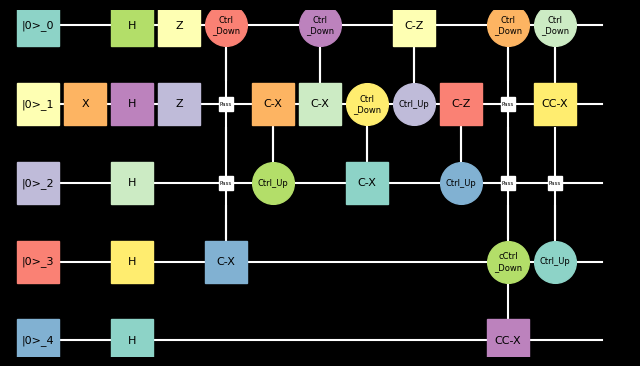

In [5]:
# Create quantum register with 5 qubits
qr = QuantumRegister(5, 'q')

# Initialize quantum circuit
qc = QuantumCircuit(qr, name='Circuit')

# Apply single-qubit gates
qc.x(qr[1])  # X gate on qubit 1
qc.h(qr['all'])  # Hadamard on all qubits
qc.z(qr[0,2])  # Z gates on qubits 0 and 2

# Apply two-qubit gates
qc.cx(qr[0], qr[3])  # CNOT: control=0, target=3
qc.cx(qr[2], qr[1])  # CNOT: control=2, target=1
qc.cx(qr[0,2], qr[1,3])  # Multiple CNOTs
qc.cz(qr[1,3], qr[0,2])  # Controlled-Z gates

# Apply three-qubit gates (Toffoli)
qc.ccx(qr[0], qr[3], qr[4])  # Toffoli: controls=(0,3), target=4
qc.ccx(qr[0], qr[3], qr[1])  # Toffoli: controls=(0,3), target=1

# Display the circuit
print(qc)

In [6]:
qc.state_vector()

Node
(
name : 'state^3_11',
tensor : 
array([[[[[ 0.35355339+0.j,  0.1767767 +0.j],
          [ 0.35355339+0.j,  0.1767767 +0.j]],

         [[ 0.35355339+0.j,  0.1767767 +0.j],
          [-0.35355339+0.j, -0.1767767 +0.j]]],


        [[[ 0.        +0.j,  0.1767767 +0.j],
          [ 0.        +0.j, -0.1767767 +0.j]],

         [[ 0.        +0.j, -0.1767767 +0.j],
          [ 0.        +0.j, -0.1767767 +0.j]]]],



       [[[[ 0.35355339+0.j,  0.1767767 +0.j],
          [ 0.35355339+0.j,  0.1767767 +0.j]],

         [[ 0.35355339+0.j,  0.1767767 +0.j],
          [-0.35355339+0.j, -0.1767767 +0.j]]],


        [[[ 0.        +0.j,  0.1767767 +0.j],
          [ 0.        +0.j, -0.1767767 +0.j]],

         [[ 0.        +0.j, -0.1767767 +0.j],
          [ 0.        +0.j, -0.1767767 +0.j]]]]]),
edges : 
[
Edge(Dangling Edge)[0] 
, 
Edge(Dangling Edge)[1] 
, 
Edge(Dangling Edge)[2] 
, 
Edge(Dangling Edge)[3] 
, 
Edge(Dangling Edge)[4] 
] 
)

Now we will test with an expected value of an operator. For that, we start by creating an operator.

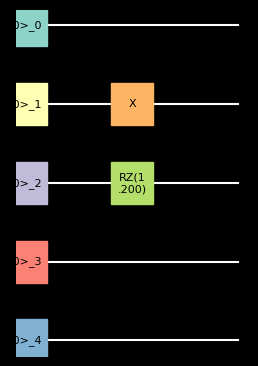

In [7]:
# Create a quantum operator circuit
operator = QuantumCircuit(5, name='Operator')
operator.x(1)
operator.rz(1.2, 2)

# Display the operator circuit
print(operator)

In [8]:
operator_gate = operator.to_gate()

And we introduce it into the circuit

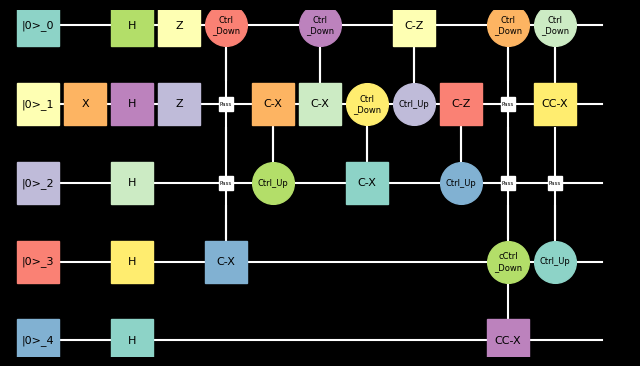

np.complex128(3.3414588882147276e-17-0.5646424733950348j)

In [9]:
# Create quantum register and circuit
qr = QuantumRegister(5, 'q')
qc = QuantumCircuit(qr, name='Circuit')

# Apply single-qubit gates
qc.x(qr[1])
qc.h(qr['all'])
qc.z(qr[0, 2])

# Apply two-qubit gates
qc.cx(qr[0], qr[3])
qc.cx(qr[2], qr[1])
qc.cx(qr[0, 2], qr[1, 3])
qc.cz(qr[1, 3], qr[0, 2])

# Apply three-qubit gates (Toffoli)
qc.ccx(qr[0], qr[3], qr[4])
qc.ccx(qr[0], qr[3], qr[1])

# Display the circuit
print(qc)

# Calculate expected value of the operator
qc.expected(operator_gate, representation='statevector', eps=0)

Let's test with another circuit and several different ways of doing it (to test each one, the entire circuit must be run from scratch, which will need to be addressed in a future version).

Statevector

In [10]:
qc = QuantumCircuit(3, name='Circuit')
qc.h(0)
qc.cx(0,1)

operator = QuantumCircuit(3, name='IZI')
operator.z(1)

operator_gate = operator.to_gate()

qc.expected(operator_gate)

np.complex128(-2.2371143170757382e-17+0j)

Approximated MPS

In [11]:
qc = QuantumCircuit(3, name='Circuit')
qc.h(0)
qc.cx(0,1)

operator = QuantumCircuit(3, name='IZI')
operator.z(1)

operator_gate = operator.to_gate()

qc.expected(operator_gate, representation='MPS',eps=0.1)

np.complex128(0j)

Now let's check a specific amplitude

In [12]:
qc = QuantumCircuit(3, name='Circuit')
qc.h(0)
qc.cx(0,1)
qc.check_state(0, 'MPS', eps=0.7)

np.complex128(0.7071067811865475+0j)

---
# Function that creates the Deutsch-Jozsa circuit

This function creates the Deutsch-Jozsa circuit for n input qubits in f(x) and a given oracle gate.

In [13]:
def Deustch_Jozsa_circuit(n_input_qubits: int, oracle) -> QuantumCircuit:
    """
    Creates a Deutsch-Jozsa quantum circuit for n input qubits.
    
    Args:
        n_input_qubits: Number of input qubits for the oracle function f(x)
        oracle: Oracle gate implementing the function to be tested
        
    Returns:
        QuantumCircuit configured for the Deutsch-Jozsa algorithm
    """
    # Create quantum registers
    qx = QuantumRegister(n_input_qubits, name='qx')  # Input register
    qy = QuantumRegister(1, name='qy')  # Output register
    
    qc = QuantumCircuit(qx, qy, name='Deutsch')
    
    # Apply initial superposition
    qc.h(qx['all'])  # Hadamard on all input qubits
    qc.x(qy[0])      # Flip output qubit to |1⟩
    qc.h(qy[0])      # Hadamard on output qubit to create |−⟩ state
    
    # Apply the oracle
    oracle_qudits = [qc.qudit_dict[qudit_id] for qudit_id in qx['all'] + [qy[0]]]
    qc.append_operator(oracle, oracle_qudits)
    
    # Apply final Hadamard layer to input qubits
    qc.h(qx['all'])
    
    return qc


---
# Function that executes the Deutsch-Jozsa algorithm

This function executes the Deutsch-Jozsa algorithm by creating the circuit, contracting it, and checking the amplitude of the 00...0 state in the x register, for both 0 and 1 in the y register, and obtaining the total. If it is approximately 0, it will be balanced, otherwise it will be constant.

Input:
- oracle: oracle in layer format.
- representation: representation for the contraction method.
- eps: error for MPS compression.

In [14]:
def Deustch_Jozsa_Algorithm(n_input_qubits: int, oracle, repr: str='MPS', eps: float=0):
    """
    Executes the Deutsch-Jozsa algorithm to determine if a function is constant or balanced.
    
    Args:
        n_input_qubits: Number of input qubits
        oracle: Oracle gate implementing the function to be tested
        repr: Representation for contraction ('MPS' or other)
        eps: Error tolerance for MPS compression
        
    Returns:
        None (prints result)
    """
    # Check amplitude for output qubit in |0⟩ state
    qc = Deustch_Jozsa_circuit(n_input_qubits, oracle)
    amp0 = qc.check_state(int('0'*(n_input_qubits+1), 2), repr, eps)
    
    # Check amplitude for output qubit in |1⟩ state
    qc = Deustch_Jozsa_circuit(n_input_qubits, oracle)
    amp1 = qc.check_state(int('1'+'0'*n_input_qubits, 2), repr, eps)
    
    # Calculate total amplitude of the all-zeros state in input register
    total_amplitude = np.sqrt(amp0**2 + amp1**2)
    
    # Determine if function is balanced or constant
    # If amplitude is ~0, the function is balanced; otherwise it's constant
    if np.round(total_amplitude, 6) == 0:
        print('Balanced function')
    else:
        print('Constant function')
    
    print(f'Amplitude of |0...0⟩ state: {total_amplitude}')


---
# Test Deustch

Let's test Deutsch with different oracles.

Balanced.

In [15]:
oracle = QuantumCircuit(3, name='Oracle')
#Balanced
oracle.cx(1,2)

oracle_gate = oracle.to_gate()

Deustch_Jozsa_Algorithm(2, oracle_gate, repr='MPS', eps=0.5)

Balanced function
Amplitude of |0...0⟩ state: 0j


Constant.

In [16]:
oracle = QuantumCircuit(3, name='Oracle')
# Constant
oracle.x(2)

oracle_gate = oracle.to_gate()

Deustch_Jozsa_Algorithm(2, oracle_gate, repr='MPS', eps=0.3)

Constant function
Amplitude of |0...0⟩ state: (0.9999999999999994+0j)
